# Group Classification (ZenML)

Train the `GroupClassifier` on real preprocessed time-group data:
- Load preprocessed time groups from .npy files in the data folder
- Train the `GroupClassifier` via a ZenML pipeline with Optuna hyperparameter tuning
- Reload artifacts and render evaluation plots (confusion matrices, ROC curves, etc.)


In [1]:
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines.training import group_classification_optuna_pipeline
from pioneerml.data import CLASS_NAMES, NUM_GROUP_CLASSES

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
# Configure the pipeline
# Use absolute path based on project root
file_pattern = str(Path(PROJECT_ROOT) / 'data' / 'mainTimeGroups_*.npy')
run = group_classification_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        # Data loading parameters
        'file_pattern': file_pattern,
        'max_files': 20,              # Limit number of files to load
        'limit_groups': 1000000,       # Cap total groups for quicker iterations
        'min_hits': 2,
        'min_hits_per_label': 2,
        # Datamodule parameters
        'batch_size': 128,
        'num_workers': None,         # None = auto-detect (uses #CPU cores - 1)
                                     # Set to 0 to disable multiprocessing
                                     # Set to a specific number to override
        'val_split': 0.15,
        'seed': 42,
    },
    run_hparam_search_params={
        'n_trials': 32,               # Optuna trials for the search step
        'max_epochs': 8,             # epochs per trial during search
        'limit_train_batches': 0.4,   # fraction/int of train batches per trial
        'limit_val_batches': 1.0,     # fraction/int of val batches per trial
    },
    train_best_model_params={
        'max_epochs': 25,             # final training epochs cap
        'early_stopping': True,        # enable early stopping
        'early_stopping_patience': 6, # patience for early stopping
        'early_stopping_monitor': 'val_loss',
        'early_stopping_mode': 'min',
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: group_classification_optuna_pipeline.
Caching is disabled by default for group_classification_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_group_classification_datamodule has started.


[build_group_classification_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_group_classification_datamodule] Starting to load data from: /home/jack/python_projects/pioneerML/data/mainTimeGroups_*.npy
[build_group_classification_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_group_classification_datamodule] Loaded 322925 groups from 11 files (pion: 109999, muon: 109918, mip: 109988)
[build_group_classification_datamodule] Loaded 322925 groups. Building datamodule...
[build_group_classification_datamodule] Calling setup(stage='fit')...
[build_group_classification_datamodule] Setup complete. Train: 274487, Val: 48438


Step build_group_classification_datamodule has finished in 25.823s.
Step run_group_classification_hparam_search has started.


[run_group_classification_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_group_classification_hparam_search] CUDA devices: 1
[run_group_classification_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_group_classification_hparam_search] Dataset sizes - Train: 274487, Val: 48438
[run_group_classification_hparam_search] Starting Optuna search with 32 trials, 8 epochs per trial...
[I 2025-12-03 03:36:18,318] A new study created in memory with name: no-name-0ee4d4e7-5fea-481e-a955-f77e4a7be8c4
[run_group_classification_hparam_search] Starting Optuna study...


  0%|          | 0/32 [00:00<?, ?it/s]

[run_group_classification_hparam_search] Trial 1/32 starting...
[run_group_classification_hparam_search] Trial 1 params: batch_size=128, hidden=256, num_blocks=3, dropout=0.1068, lr=0.002726, weight_decay=0.000035
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 1 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 1 completed with score: 0.994797
[run_group_classification_hparam_search] Trial 2/32 starting...
[run_group_classification_hparam_search] Trial 2 params: batch_size=32, hidden=128, num_blocks=3, dropout=0.1371, lr=0.000797, weight_decay=0.000033
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 2 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 03:44:17,247] Trial 0 finished with value: 0.9947974681854248 and parameters: {'batch_size': 128, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.10676661207128675, 'lr': 0.0027264445655920916, 'weight_decay': 3.4532152249090445e-05}. Best is trial 0 with value: 0.9947974681854248.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 2 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 2 completed with score: 0.940150
[run_group_classification_hparam_search] Trial 3/32 starting...
[run_group_classification_hparam_search] Trial 3 params: batch_size=64, hidden=192, num_blocks=3, dropout=0.1462, lr=0.000385, weight_decay=0.000164
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 3 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 04:03:58,053] Trial 1 finished with value: 0.9401499032974243 and parameters: {'batch_size': 32, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.13707465521611908, 'lr': 0.0007965134219367082, 'weight_decay': 3.2897378261079306e-05}. Best is trial 0 with value: 0.9947974681854248.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 3 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 3 completed with score: 0.998184
[run_group_classification_hparam_search] Trial 4/32 starting...
[run_group_classification_hparam_search] Trial 4 params: batch_size=32, hidden=128, num_blocks=4, dropout=0.1305, lr=0.000341, weight_decay=0.000587
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 4 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 04:14:25,262] Trial 2 finished with value: 0.9981837868690491 and parameters: {'batch_size': 64, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.146195565886366, 'lr': 0.0003848745518956178, 'weight_decay': 0.00016393185491058083}. Best is trial 2 with value: 0.9981837868690491.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 4 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 4 completed with score: 0.999002
[run_group_classification_hparam_search] Trial 5/32 starting...
[run_group_classification_hparam_search] Trial 5 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.1185, lr=0.001338, weight_decay=0.000017
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 5 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 04:37:04,618] Trial 3 finished with value: 0.9990024566650391 and parameters: {'batch_size': 32, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.1304706808678974, 'lr': 0.00034128346730933685, 'weight_decay': 0.0005870277369757065}. Best is trial 3 with value: 0.9990024566650391.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 5 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 5 completed with score: 0.997130
[run_group_classification_hparam_search] Trial 6/32 starting...
[run_group_classification_hparam_search] Trial 6 params: batch_size=32, hidden=128, num_blocks=4, dropout=0.1866, lr=0.000519, weight_decay=0.000470
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 6 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 04:49:00,723] Trial 4 finished with value: 0.9971304535865784 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.11849334854779091, 'lr': 0.0013379072064979632, 'weight_decay': 1.7143600217426066e-05}. Best is trial 3 with value: 0.9990024566650391.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 6 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 6 completed with score: 0.998239
[run_group_classification_hparam_search] Trial 7/32 starting...
[run_group_classification_hparam_search] Trial 7 params: batch_size=32, hidden=192, num_blocks=3, dropout=0.2422, lr=0.002362, weight_decay=0.000182
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 7 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 05:11:22,344] Trial 5 finished with value: 0.9982385635375977 and parameters: {'batch_size': 32, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.18655423316444253, 'lr': 0.000518758082042696, 'weight_decay': 0.00046959205434855085}. Best is trial 3 with value: 0.9990024566650391.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 7 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 7 completed with score: 0.996140
[run_group_classification_hparam_search] Trial 8/32 starting...
[run_group_classification_hparam_search] Trial 8 params: batch_size=64, hidden=128, num_blocks=3, dropout=0.1939, lr=0.000370, weight_decay=0.000081
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 8 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 05:30:56,589] Trial 6 finished with value: 0.9961399435997009 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.24215426933973927, 'lr': 0.002361875708207532, 'weight_decay': 0.00018235007025554204}. Best is trial 3 with value: 0.9990024566650391.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 8 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 8 completed with score: 0.999099
[run_group_classification_hparam_search] Trial 9/32 starting...
[run_group_classification_hparam_search] Trial 9 params: batch_size=64, hidden=256, num_blocks=2, dropout=0.1329, lr=0.000463, weight_decay=0.000661
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 9 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 05:41:16,592] Trial 7 finished with value: 0.9990991353988647 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.19387310336288804, 'lr': 0.0003695915054926643, 'weight_decay': 8.09950223178575e-05}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 9 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 9 completed with score: 0.998417
[run_group_classification_hparam_search] Trial 10/32 starting...
[run_group_classification_hparam_search] Trial 10 params: batch_size=128, hidden=256, num_blocks=3, dropout=0.2375, lr=0.000487, weight_decay=0.000072
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 10 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 05:50:31,775] Trial 8 finished with value: 0.9984171986579895 and parameters: {'batch_size': 64, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.13286963700041354, 'lr': 0.0004633268758115793, 'weight_decay': 0.0006613310562888837}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 10 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 10 completed with score: 0.997777
[run_group_classification_hparam_search] Trial 11/32 starting...
[run_group_classification_hparam_search] Trial 11 params: batch_size=64, hidden=128, num_blocks=2, dropout=0.1844, lr=0.000921, weight_decay=0.000011
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 11 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 05:57:16,468] Trial 9 finished with value: 0.9977774620056152 and parameters: {'batch_size': 128, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.23754776951619389, 'lr': 0.00048732791393246174, 'weight_decay': 7.167424069886095e-05}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 11 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 11 completed with score: 0.998899
[run_group_classification_hparam_search] Trial 12/32 starting...
[run_group_classification_hparam_search] Trial 12 params: batch_size=32, hidden=128, num_blocks=4, dropout=0.0551, lr=0.000308, weight_decay=0.000326
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 12 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 06:06:28,022] Trial 10 finished with value: 0.9988992214202881 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.1844401295901497, 'lr': 0.0009212561989368032, 'weight_decay': 1.1175390398983146e-05}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 12 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 12 completed with score: 0.999023
[run_group_classification_hparam_search] Trial 13/32 starting...
[run_group_classification_hparam_search] Trial 13 params: batch_size=32, hidden=128, num_blocks=4, dropout=0.0513, lr=0.000302, weight_decay=0.000272
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 13 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 06:28:46,630] Trial 11 finished with value: 0.9990232586860657 and parameters: {'batch_size': 32, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.055094375774398935, 'lr': 0.00030799536215375336, 'weight_decay': 0.00032640858572954205}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 13 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 13 completed with score: 0.999044
[run_group_classification_hparam_search] Trial 14/32 starting...
[run_group_classification_hparam_search] Trial 14 params: batch_size=64, hidden=128, num_blocks=2, dropout=0.0631, lr=0.000645, weight_decay=0.000083
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 14 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 06:51:02,249] Trial 12 finished with value: 0.999043881893158 and parameters: {'batch_size': 32, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.05126337809059325, 'lr': 0.0003024234970754615, 'weight_decay': 0.0002724685244129689}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 14 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 14 completed with score: 0.998858
[run_group_classification_hparam_search] Trial 15/32 starting...
[run_group_classification_hparam_search] Trial 15 params: batch_size=128, hidden=128, num_blocks=4, dropout=0.1846, lr=0.001396, weight_decay=0.000207
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 15 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 06:59:58,417] Trial 13 finished with value: 0.9988579154014587 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.06310533932553901, 'lr': 0.000645362231238953, 'weight_decay': 8.318861960786652e-05}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 15 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 15 completed with score: 0.997151
[run_group_classification_hparam_search] Trial 16/32 starting...
[run_group_classification_hparam_search] Trial 16 params: batch_size=32, hidden=192, num_blocks=3, dropout=0.0890, lr=0.000312, weight_decay=0.000048
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 16 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 07:06:43,146] Trial 14 finished with value: 0.997151255607605 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.18457811878826588, 'lr': 0.001395788861088448, 'weight_decay': 0.0002070126037197336}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 16 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 16 completed with score: 0.998934
[run_group_classification_hparam_search] Trial 17/32 starting...
[run_group_classification_hparam_search] Trial 17 params: batch_size=64, hidden=128, num_blocks=3, dropout=0.2041, lr=0.000612, weight_decay=0.000145
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 17 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 07:26:16,310] Trial 15 finished with value: 0.9989336133003235 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.08898771100339181, 'lr': 0.00031158897694711095, 'weight_decay': 4.7897199613660507e-05}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 17 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 17 completed with score: 0.995211
[run_group_classification_hparam_search] Trial 18/32 starting...
[run_group_classification_hparam_search] Trial 18 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.1636, lr=0.000418, weight_decay=0.000322
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 18 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 07:36:42,722] Trial 16 finished with value: 0.9952109456062317 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.2040868596161406, 'lr': 0.0006122955549534144, 'weight_decay': 0.00014513316328851813}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 18 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 18 completed with score: 0.999037
[run_group_classification_hparam_search] Trial 19/32 starting...
[run_group_classification_hparam_search] Trial 19 params: batch_size=32, hidden=256, num_blocks=2, dropout=0.2129, lr=0.001214, weight_decay=0.000107
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 19 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 07:48:36,314] Trial 17 finished with value: 0.9990368485450745 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.16359562242936537, 'lr': 0.0004184983764039423, 'weight_decay': 0.0003219626629912159}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 19 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 19 completed with score: 0.997853
[run_group_classification_hparam_search] Trial 20/32 starting...
[run_group_classification_hparam_search] Trial 20 params: batch_size=128, hidden=192, num_blocks=3, dropout=0.0821, lr=0.000663, weight_decay=0.000979
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 20 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 08:05:44,639] Trial 18 finished with value: 0.9978531002998352 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.2128613182179761, 'lr': 0.0012139142165484098, 'weight_decay': 0.00010673636924067009}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 20 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 20 completed with score: 0.998948
[run_group_classification_hparam_search] Trial 21/32 starting...
[run_group_classification_hparam_search] Trial 21 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.1626, lr=0.001782, weight_decay=0.000283
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 21 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 08:11:54,397] Trial 19 finished with value: 0.9989476799964905 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.08213343835520569, 'lr': 0.0006625464904215454, 'weight_decay': 0.0009787744940478833}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 21 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 21 completed with score: 0.995087
[run_group_classification_hparam_search] Trial 22/32 starting...
[run_group_classification_hparam_search] Trial 22 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.1676, lr=0.000418, weight_decay=0.000328
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 22 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 08:23:39,112] Trial 20 finished with value: 0.9950871467590332 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.1625781701018562, 'lr': 0.0017822565649221354, 'weight_decay': 0.0002825320860956864}. Best is trial 7 with value: 0.9990991353988647.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 22 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 22 completed with score: 0.999120
[run_group_classification_hparam_search] Trial 23/32 starting...
[run_group_classification_hparam_search] Trial 23 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.2194, lr=0.000362, weight_decay=0.000110
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 23 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 08:35:34,781] Trial 21 finished with value: 0.9991195797920227 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.1675984580563084, 'lr': 0.0004183225138581784, 'weight_decay': 0.0003275599625318856}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 23 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 23 completed with score: 0.999030
[run_group_classification_hparam_search] Trial 24/32 starting...
[run_group_classification_hparam_search] Trial 24 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.1650, lr=0.000408, weight_decay=0.000057
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 24 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 08:47:48,876] Trial 22 finished with value: 0.9990298748016357 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.219358106778347, 'lr': 0.0003616011475905167, 'weight_decay': 0.0001103855600016782}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 24 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 24 completed with score: 0.998576
[run_group_classification_hparam_search] Trial 25/32 starting...
[run_group_classification_hparam_search] Trial 25 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.2043, lr=0.000555, weight_decay=0.000255
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 25 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 08:59:32,946] Trial 23 finished with value: 0.9985759854316711 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.16495603452957144, 'lr': 0.0004082987547668321, 'weight_decay': 5.722221400599673e-05}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 25 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 25 completed with score: 0.998968
[run_group_classification_hparam_search] Trial 26/32 starting...
[run_group_classification_hparam_search] Trial 26 params: batch_size=32, hidden=128, num_blocks=3, dropout=0.1704, lr=0.000396, weight_decay=0.000120
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 26 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 09:11:16,538] Trial 24 finished with value: 0.998968243598938 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.2043365957966975, 'lr': 0.0005547683425370701, 'weight_decay': 0.00025466791032744914}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 26 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 26 completed with score: 0.998617
[run_group_classification_hparam_search] Trial 27/32 starting...
[run_group_classification_hparam_search] Trial 27 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.0949, lr=0.000762, weight_decay=0.000469
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 27 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 09:30:52,438] Trial 25 finished with value: 0.9986171722412109 and parameters: {'batch_size': 32, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.17035032474679207, 'lr': 0.00039639093194051347, 'weight_decay': 0.00011957933194564925}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 27 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 27 completed with score: 0.998549
[run_group_classification_hparam_search] Trial 28/32 starting...
[run_group_classification_hparam_search] Trial 28 params: batch_size=64, hidden=128, num_blocks=3, dropout=0.0687, lr=0.000465, weight_decay=0.000884
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 28 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 09:42:41,893] Trial 26 finished with value: 0.9985485672950745 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.0948771267938692, 'lr': 0.000762075410460579, 'weight_decay': 0.00046880477646940095}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 28 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 28 completed with score: 0.999119
[run_group_classification_hparam_search] Trial 29/32 starting...
[run_group_classification_hparam_search] Trial 29 params: batch_size=64, hidden=256, num_blocks=3, dropout=0.0730, lr=0.000440, weight_decay=0.000927
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 29 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 09:53:05,618] Trial 27 finished with value: 0.9991194605827332 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.0687088246800763, 'lr': 0.00046460909413732207, 'weight_decay': 0.0008836768530248769}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 29 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 29 completed with score: 0.999016
[run_group_classification_hparam_search] Trial 30/32 starting...
[run_group_classification_hparam_search] Trial 30 params: batch_size=128, hidden=192, num_blocks=3, dropout=0.1190, lr=0.001003, weight_decay=0.000033
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 30 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 10:04:02,363] Trial 28 finished with value: 0.9990160465240479 and parameters: {'batch_size': 64, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.07304786833201578, 'lr': 0.0004404592449384242, 'weight_decay': 0.0009272557061132595}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 30 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 30 completed with score: 0.996470
[run_group_classification_hparam_search] Trial 31/32 starting...
[run_group_classification_hparam_search] Trial 31 params: batch_size=64, hidden=256, num_blocks=3, dropout=0.2253, lr=0.000548, weight_decay=0.000701
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 31 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 10:10:17,833] Trial 29 finished with value: 0.9964698553085327 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.11896364271390678, 'lr': 0.0010028979532130935, 'weight_decay': 3.257106382393245e-05}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 31 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 31 completed with score: 0.991025
[run_group_classification_hparam_search] Trial 32/32 starting...
[run_group_classification_hparam_search] Trial 32 params: batch_size=64, hidden=128, num_blocks=3, dropout=0.0572, lr=0.000346, weight_decay=0.000406
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 32 training 8 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-03 10:21:07,761] Trial 30 finished with value: 0.9910253286361694 and parameters: {'batch_size': 64, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.22530033475690783, 'lr': 0.0005483242244541459, 'weight_decay': 0.0007013517162405111}. Best is trial 21 with value: 0.9991195797920227.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


[run_group_classification_hparam_search] Trial 32 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 32 completed with score: 0.998996
[run_group_classification_hparam_search] Optuna search complete! Best score: 0.999120
[run_group_classification_hparam_search] Best params: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.1675984580563084, 'lr': 0.0004183225138581784, 'weight_decay': 0.0003275599625318856}


[I 2025-12-03 10:31:49,023] Trial 31 finished with value: 0.9989956021308899 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.057248293330879066, 'lr': 0.00034629724607705735, 'weight_decay': 0.00040644376633089906}. Best is trial 21 with value: 0.9991195797920227.
Step run_group_classification_hparam_search has finished in 6h57m29s.
Step train_best_group_classifier has started.


[train_best_group_classifier] Starting final model training...
[train_best_group_classifier] Dataset sizes - Train: 274487, Val: 48438
[train_best_group_classifier] Using GPU: NVIDIA GeForce RTX 5070
[train_best_group_classifier] CUDA devices: 1
[train_best_group_classifier] Enabled Tensor Core optimization (medium precision)
[train_best_group_classifier] Training configuration:
[train_best_group_classifier]   max_epochs: 25
[train_best_group_classifier]   early_stopping: True
[train_best_group_classifier]   early_stopping_patience: 6
[train_best_group_classifier] Starting training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 0.027
Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.009
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006
Monitored metric val_loss did not improve in the last 6 records. Best score: 0.006. Signaling Trainer to stop.


[train_best_group_classifier] Training complete! Final epoch: 15


Step train_best_group_classifier has finished in 47m14s.
Step collect_group_classification_predictions has started.
Step collect_group_classification_predictions has finished in 4m18s.
Pipeline run has finished in 7h49m33s.
Run name: group_classification_optuna_pipeline-2025_12_03-08_33_51_957863
Run status: completed


In [3]:
trained_module = load_step_output(run, "train_best_group_classifier")
datamodule = load_step_output(run, "build_group_classification_datamodule")
predictions = load_step_output(run, "collect_group_classification_predictions", index=0)
targets = load_step_output(run, "collect_group_classification_predictions", index=1)
best_params = load_step_output(run, "run_group_classification_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))


Loaded module on cpu; validation samples: 48438
Best params from Optuna: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.1675984580563084, 'lr': 0.0004183225138581784, 'weight_decay': 0.0003275599625318856, 'best_score': 0.9991195797920227, 'n_trials': 32} {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.1675984580563084, 'lr': 0.0004183225138581784, 'weight_decay': 0.0003275599625318856, 'best_score': 0.9991195797920227, 'n_trials': 32}
Epochs actually run: 15 15


In [4]:
# Class names for group classification
class_names = [CLASS_NAMES[i] for i in range(NUM_GROUP_CLASSES)]
print("Class names (index-aligned):", class_names)


Class names (index-aligned): ['pion', 'muon', 'mip'] ['pion', 'muon', 'mip']


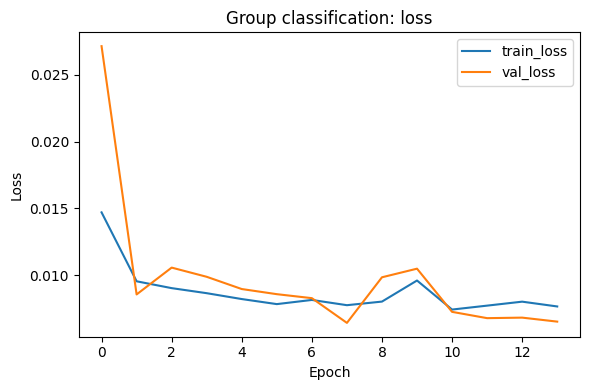

/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



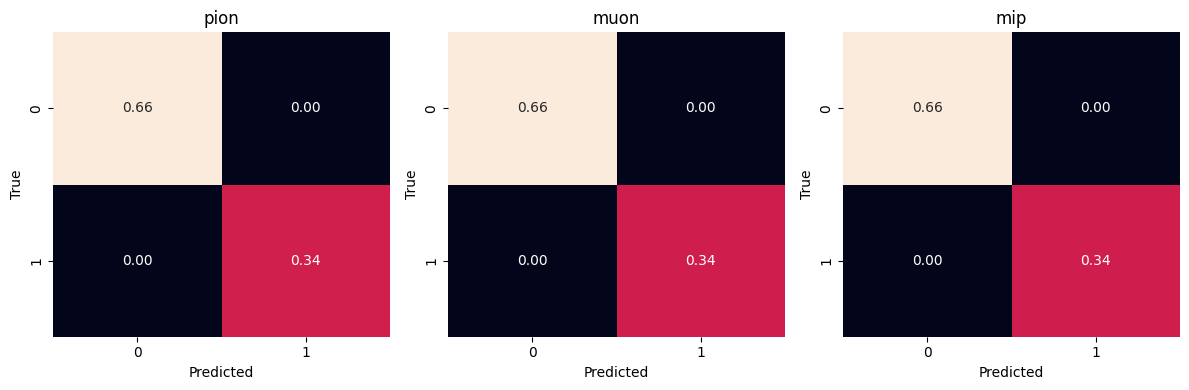

/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



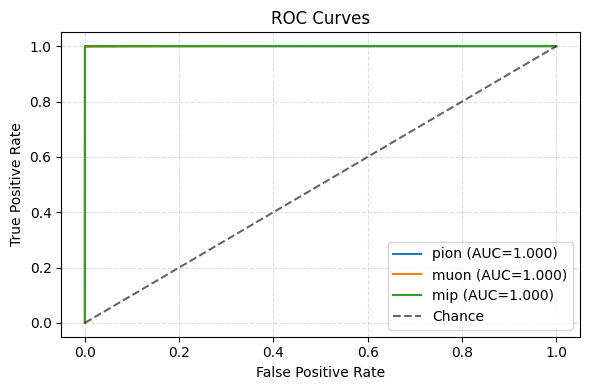

/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



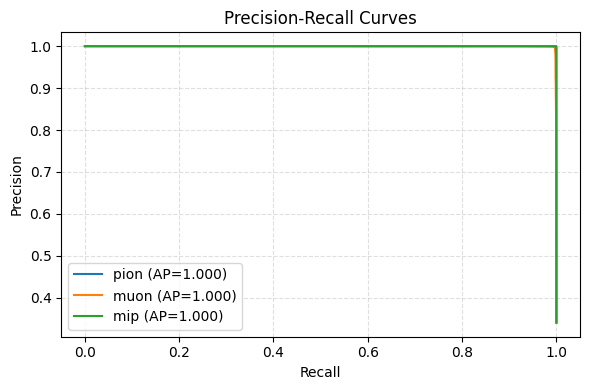

In [5]:
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)

plot_loss_curves(trained_module, title="Group classification: loss", show=True)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)
plot_roc_curves(predictions, targets, class_names=class_names, show=True)
plot_precision_recall_curves(predictions, targets, class_names=class_names, show=True)


## Save the Trained Model

Save the trained model and metadata for later use.


In [ ]:
import torch
import json
from datetime import datetime

# Create checkpoints directory
checkpoints_dir = Path(PROJECT_ROOT) / "trained_models" / "group_classifier"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

# Generate a timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"group_classifier_{timestamp}.pt"
metadata_filename = f"group_classifier_{timestamp}_metadata.json"

# Extract the underlying model from the Lightning module
model = trained_module.model
model.eval()

# Save model state_dict
model_path = checkpoints_dir / model_filename
torch.save(model.state_dict(), model_path)
print(f"Saved model state_dict to: {model_path}")

# Save metadata (hyperparameters, training info, etc.)
metadata = {
    "model_type": "GroupClassifier",
    "timestamp": timestamp,
    "run_name": run.name,
    "best_hyperparameters": best_params,
    "training_config": getattr(trained_module, "training_config", {}),
    "epochs_run": getattr(trained_module, "final_epochs_run", None),
    "dataset_info": {
        "train_size": len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        "val_size": len(datamodule.val_dataset) if datamodule.val_dataset else 0,
        "num_classes": NUM_GROUP_CLASSES,
        "class_names": class_names,
    },
    "model_architecture": {
        "num_classes": NUM_GROUP_CLASSES,
        "hidden": best_params.get("hidden"),
        "num_blocks": best_params.get("num_blocks"),
        "dropout": best_params.get("dropout"),
    },
}

metadata_path = checkpoints_dir / metadata_filename
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to: {metadata_path}")

print(f"\nModel saved successfully!")
print(f"  Model: {model_path}")
print(f"  Metadata: {metadata_path}")


Saved model state_dict to: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_112338.pt
Saved metadata to: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_112338_metadata.json

Model saved successfully!
  Model: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_112338.pt
  Metadata: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier/group_classifier_20251203_112338_metadata.json
